# Scrape Liquor.com

### Imports and Functions

In [1]:
import pandas as pd
import requests
import unicodedata
from bs4 import BeautifulSoup

from code.lw_pickle import var_to_pickle, read_pickle

### Get List of Cocktail Links

In [2]:
links_pk = '../data/li_drink_links.pk'
drink_links = read_pickle(links_pk)

# Scrape data only if pickle of links does not exist
if not drink_links:
    drink_links = []
    url_base = 'https://www.liquor.com/recipes/page/%i'
    for page in range(1, 100):
        url = url_base % page
        response = requests.get(url)

        # Breaks loop early if page returns 404 status
        if response.status_code == 404:
            print(f'\nBroke on 404 for \'{url}\'' )
            break

        # Scrapes page for cocktail name, link, and image file
        soup = BeautifulSoup(response.text, 'lxml')
        page_divs = soup.findAll('div', {'class':'item card card-type-recipe'})
        for div in page_divs:

            # Ignores partner content
            if div.find('div', {'class':'partner-content sans'}):
                continue
            
            div_dict = {}
            div_dict['name'] = div.h3.a.text
            div_dict['url'] = div.h3.a.get('href')
            div_dict['image'] = div.div.get('data-href')[2:]
            drink_links.append(div_dict)
            
    # Writes out pickle of links
    var_to_pickle(drink_links, links_pk)

In [3]:
drink_df = pd.DataFrame(drink_links)
drink_df.sort_values(by='name', inplace=True)
drink_df.drop_duplicates(inplace=True)
drink_df.reset_index(drop=True, inplace=True)
drink_df.shape

(2045, 3)

### Get Recipes and Descriptions

In [4]:
recipes_pk = '../data/li_recipes.pk'
recipes = read_pickle(recipes_pk)

# Scrape data only if pickle of links does not exist
if not recipes:
    recipes = []
    for ind in drink_df.index:
        response = requests.get(drink_df.loc[ind]['url'])
        soup = BeautifulSoup(response.text, 'lxml')
        recipe_dict = {}

        # Gets description
        desc = soup.find('span', {'itemprop':'description'})
        if desc:
            recipe_dict['description'] = desc.p.text.replace(u'\xa0', ' ').strip()
        else:
            recipe_dict['description'] = None

        # Gets ingredients
        ingredients = soup.findAll('div', {'itemprop':'recipeIngredient'})
        if ingredients:
            recipe_dict['ingredients'] = [ing.text.replace(u'\xa0', ' ').strip()
                                          for ing in ingredients]
        else:
            recipe_dict['ingredients'] = []

        # Gets garnishes
        garnishes = soup.findAll('div', {'class':'col-xs-9 recipe-link no-padding'})
        if garnishes:
            recipe_dict['garnishes'] = [gar.span.text.replace(u'\xa0', ' ').strip()
                                        for gar in garnishes]
        else:
            recipe_dict['garnishes'] = []

        # Gets glass type
        glass = soup.find('div', {'class':'col-xs-9 recipe-link x-recipe-glasstype no-padding'})
        if glass:
            recipe_dict['glass'] = glass.text.replace(u'\xa0', ' ').strip()
        else:
            recipe_dict['glass'] = None

        # Gets instructions
        instructions = soup.find('div', {'itemprop':'recipeInstructions'})
        if instructions:
            inst_str = '. '.join([inst.text.replace(u'\xa0', ' ').strip()
                                  for inst in instructions.findAll('p')])
            if inst_str:
                inst_str += '.'
            recipe_dict['instructions'] = inst_str
        else:
            recipe_dict['instructions'] = None

        # Gets flavor information
        flavors = soup.find('div', {'class':'col-xs-12 text-center x-recipe-flavor recipe-link'})
        if flavors:
            recipe_dict['flavors'] = [flv.text.replace(u'\xa0', ' ').strip()
                                      for flv in flavors.findAll('a')]
        else:
            recipe_dict['flavors'] = []

        # Gets base spirits
        bases = soup.find('div', {'class':'col-xs-7 x-recipe-spirit'})
        if bases:
            recipe_dict['base_spirits'] = [base.text.replace(u'\xa0', ' ').strip()
                                           for base in bases.findAll('a')]
        else:
            recipe_dict['base_spirits'] = []

        # Gets cocktail type
        cocktail_type = soup.find('div', {'class':'col-xs-7 x-recipe-type'})
        if cocktail_type:
            recipe_dict['type'] = cocktail_type.text.replace(u'\xa0', ' ').strip()
        else:
            recipe_dict['type'] = None

        recipes.append(recipe_dict)
        
    # Writes out pickle of recipes
    var_to_pickle(recipes, recipes_pk)

### Merge Dataframe

In [5]:
drink_df = drink_df.merge(pd.DataFrame(recipes), left_index=True, right_index=True)

### Add Description Lengths

In [6]:
drink_df = drink_df[drink_df['description'].notna()]
drink_df.reset_index(drop=True, inplace=True)

In [7]:
drink_df['desc_length'] = drink_df['description'].str.len()

### Pre-process Descriptions

In [43]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
desc_prepro = lambda desc: re.sub('[^\w ]*', '', desc.lower())
drink_df['proc_desc'] = drink_df['description'].map(desc_prepro)

In [45]:
drink_df.sample(5)

,image,name,url,base_spirits,description,flavors,garnishes,glass,ingredients,instructions,type,desc_length,proc_desc
702,cdn.liquor.com/wp-content/uploads/2017/04/1113...,Gin Buck,https://www.liquor.com/recipes/gin-buck/,[Gin],"The simple, sweet and bubbly Gin Buck was a po...","[Bubbly, Sweet]",[Lemon or lime wedge],Collins,"[1 1⁄2 oz GinTry it with Bombay Sapphire, Juic...",Fill a Collins glass with ice and add the gin ...,Classics,90,the simple sweet and bubbly gin buck was a pop...
1043,cdn.liquor.com/wp-content/uploads/2016/12/0512...,Lynx,https://www.liquor.com/recipes/lynx/,[Cognac],If you’re looking to add a little chill to you...,[Bitter],[],Rocks,"[1 oz Maison Rouge cognac, 3⁄4 oz Cream, 1⁄2 o...","Combine all of the ingredients, except for the...",Modern Classics,325,if youre looking to add a little chill to your...
67,cdn.liquor.com/wp-content/uploads/2014/03/reci...,Ancho Old Fashioned,https://www.liquor.com/recipes/ancho-old-fashi...,"[Liqueurs, Tequila]",Put some chile fire in your Old Fashioned.,"[Spicy, Spirit-forward, Sweet]",[1 Orange and lemon twists],Double Old Fashioned,"[1 oz Milagro Silver Tequila, 1 oz Ancho Reyes...",Add all the ingredients to a mixing glass and ...,None,42,put some chile fire in your old fashioned
1432,cdn.liquor.com/wp-content/uploads/2010/05/roya...,Royal Smash,https://www.liquor.com/recipes/royal-smash/,[Liqueurs],Drink like a blue blood for the evening.,"[Fruity/Citrus-forward, Sour, Sweet]",[1 Mint sprig],Rocks,"[1⁄2 Fresh lemon, quartered, Mint leaves, 2 o...","In a shaker, muddle the mint and lemon.. Add t...",Modern Classics,40,drink like a blue blood for the evening
1310,cdn.liquor.com/wp-content/uploads/2019/02/1309...,Piña Colada,https://www.liquor.com/recipes/pina-colada/,[Rum],The Piña Colada gets a bad rap among cocktail ...,"[Creamy, Fruity/Citrus-forward, Sweet]","[Pineapple wedge, Pineapple leaf]",Hurricane,"[2 oz Light rumTry it with Bacardí Superior, 1...",Add all ingredients into a shaker with ice and...,Tiki / Tropical,428,the piña colada gets a bad rap among cocktail ...


### Stop Words

In [94]:
from sklearn.feature_extraction import text

In [95]:
text.ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

### Train KMeans Model

In [54]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

In [47]:
tfv = TfidfVectorizer(stop_words='english')
descriptions = tfv.fit_transform(drink_df['proc_desc'].values)

In [56]:
inertias = []
sil_scores = []
k_clusters = range(2, 30)
for k in k_clusters:
    km = KMeans(n_clusters=k)
    km.fit(descriptions)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(descriptions, km.labels_, metric='euclidean'))

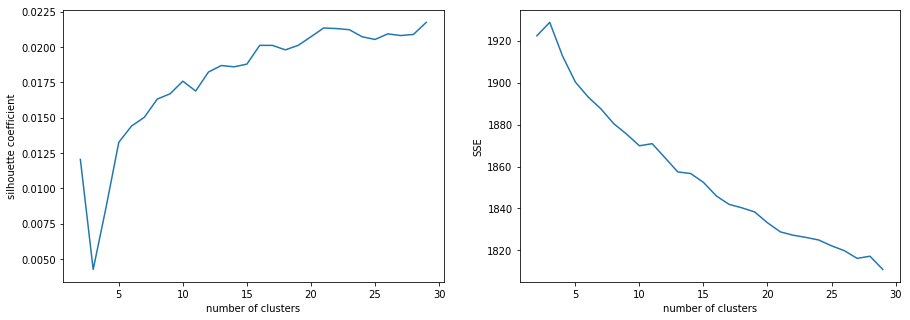

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
ax1.plot(k_clusters, sil_scores)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, inertias)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [58]:
km = KMeans(n_clusters=16)
km.fit(descriptions)
drink_df['cluster'] = km.labels_

### Examine Results

In [59]:
drink_df['cluster'].value_counts()

2     543
11    373
13    122
1     120
9     116
5     113
7     100
0      82
14     79
12     71
8      69
6      57
15     41
10     37
3      27
4      20
Name: cluster, dtype: int64

In [83]:
for c in sorted(drink_df['cluster'].unique()):
    print(f'Cluster {c}:')
    for x in drink_df[drink_df['cluster'] == c].sample(10)[['base_spirits', 'flavors']].values:
        print(', '.join(x[0]).ljust(30)[:30], '\t', ', '.join(x[1])[:30])
    print('')

Cluster 0:
                               	 
Champagne & Sparkling Wine     	 Bubbly, Sour, Sweet
                               	 
Vodka                          	 Salty/Savory, Spicy
Bourbon / American Whiskey     	 Bubbly, Fruity/Citrus-forward,
                               	 Bitter
Mezcal                         	 Spicy
Cognac                         	 Fruity/Citrus-forward
Rum                            	 Fruity/Citrus-forward
Vermouth / Aperitif Wine, Vodk 	 Fruity/Citrus-forward, Sour, S

Cluster 1:
Wine                           	 Fruity/Citrus-forward, Sweet
Vodka                          	 Bubbly, Fruity/Citrus-forward,
Vodka                          	 Creamy, Fruity/Citrus-forward
Tequila                        	 Fruity/Citrus-forward
Vodka                          	 Creamy, Fruity/Citrus-forward,
Vodka                          	 Sweet
Pisco                          	 Bubbly, Sour, Sweet
Vodka                          	 Bubbly
Vodka                          	 Fruity/Citrus

In [97]:
sorted(tfv.vocabulary_.items())

[('10', 0),
 ('100', 1),
 ('10000squarefoot', 2),
 ('100proof', 3),
 ('101', 4),
 ('102', 5),
 ('10th', 6),
 ('10yearold', 7),
 ('10yearoldscotch', 8),
 ('11', 9),
 ('12', 10),
 ('120', 11),
 ('12madison', 12),
 ('12yearold', 13),
 ('130', 14),
 ('135', 15),
 ('14', 16),
 ('1495', 17),
 ('1499of', 18),
 ('15', 19),
 ('151', 20),
 ('1595', 21),
 ('1691', 22),
 ('16seat', 23),
 ('16thcentury', 24),
 ('1799', 25),
 ('1800s', 26),
 ('1805', 27),
 ('1830s', 28),
 ('1835', 29),
 ('1840', 30),
 ('1849', 31),
 ('1850s', 32),
 ('185f', 33),
 ('1862', 34),
 ('1880', 35),
 ('1884', 36),
 ('1890s', 37),
 ('1896', 38),
 ('18th', 39),
 ('19', 40),
 ('1900s', 41),
 ('1920s', 42),
 ('1920s30s', 43),
 ('1922', 44),
 ('1927', 45),
 ('1928', 46),
 ('1930', 47),
 ('1930s', 48),
 ('1937', 49),
 ('1938', 50),
 ('1939', 51),
 ('1940s', 52),
 ('1944', 53),
 ('1946', 54),
 ('1950s', 55),
 ('1952', 56),
 ('1953', 57),
 ('1967', 58),
 ('1970', 59),
 ('1970s', 60),
 ('1970sera', 61),
 ('1978', 62),
 ('1988', 63),